In [1]:
import praw
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# Authentication 
reddit = praw.Reddit(client_id='',
                     client_secret='',
                     user_agent='',
                     username='',
                     password='')

In [3]:
# Define functions for future data scraping 

In [4]:
def get_posts(sub_name, n):
    subreddit = reddit.subreddit(sub_name)
    posts_list = [] 
    
    for submission in subreddit.top(limit=n):
        info_list = []
        info_list.append(submission.id)   # Output: the submission's title
        info_list.append(submission.score)  # Output: the submission's score  
        info_list.append(str(submission.author)) 
        info_list.append(submission.num_comments)
        info_list.append(submission.subreddit)
        posts_list.append(info_list)
    
    a = sorted(posts_list, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(a, columns = ['id', 'score', 'author', 'num_comments', 'subreddit'])
    return posts_df

In [5]:
def get_comments(subm_id, n): 
    
    com_list = []
    submission = reddit.submission(id = subm_id)
    i = 0
    for comment in submission.comments:
        info_list = []
            # Top 3 comments for each submission
        if i <= n:
            info_list.append(comment.id)
            info_list.append(comment.score)
            info_list.append(comment.author)
            info_list.append(submission.subreddit)
            #info_list.append(submission.comments.list()[i].body)
            i += 1
            com_list.append(info_list)
        else:
            break
    
    a = sorted(com_list, key=lambda x: x[1], reverse = True)
    com_df = pd.DataFrame(a)
    return com_df   

In [6]:
def get_user_posts(author, n):
    
    redditor = reddit.redditor(author)
    user_posts_list = []
    
    for submission in redditor.submissions.top(limit = n):
        info_list = []
        info_list.append(submission.id)
        info_list.append(submission.score)
        info_list.append(str(submission.author))
        info_list.append(submission.num_comments)
        info_list.append(str(submission.subreddit))
        user_posts_list.append(info_list)
    
    a = sorted(user_posts_list, key=lambda x: x[1], reverse = True)
    user_posts_df = pd.DataFrame(a)
    return user_posts_df 

# Initial Analysis of r/all

In [7]:
# First we scrape 1000 posts, then using submission id, scrape most popular comments of every post and append it to the 
# dataframe with comments 
df = get_posts('all', 1000)

In [9]:
df.shape # Explore posts dataframe

(945, 5)

In [10]:
df.head(10)

,id,score,author,num_comments,subreddit
0,5gn8ru,283479,iH8myPP,5017,funny
1,5bx4bx,230837,Itsjorgehernandez,6113,pics
2,5sfexx,222807,datbanter,4368,pics
3,z1c9z,216152,PresidentObama,23200,IAmA
4,5jrlw1,204191,iswearidk,5668,gifs
5,5y51v9,168686,BigCballer,1322,funny
6,5by1wy,163307,Zykium,8732,pics
7,5pqxdk,157909,GallowBoob,5320,pics
8,4d75i7,154761,mister_geaux,12222,worldnews
9,5fk6rm,142160,spitonem,2088,gifs


In [12]:
df.author.nunique()

770

In [13]:
df.subreddit.nunique()

52

In [14]:
df['score'].describe()

count       945.000000
mean      76176.911111
std       19829.558195
min       59740.000000
25%       64294.000000
50%       70596.000000
75%       80760.000000
max      283486.000000
Name: score, dtype: float64

In [15]:
df['num_comments'].describe()

count      945.000000
mean      3242.501587
std       4635.728545
min        355.000000
25%       1227.000000
50%       2051.000000
75%       3495.000000
max      80407.000000
Name: num_comments, dtype: float64

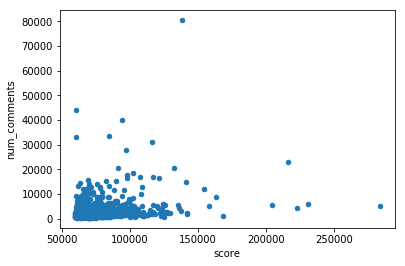

In [16]:
df.plot('score', 'num_comments', kind = 'scatter' )

# Analysis based on a r/marvelstudios

In [16]:
import matplotlib.pyplot as plt

In [8]:
marvel_df = get_posts('marvelstudios', 500) # This is where you can define any subreddit and 
                                            # run all the cells to get the network graph

In [9]:
marvel_df.author.nunique() # Out of 500, 434 are unique 

434

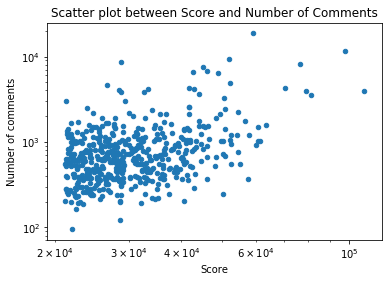

In [39]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [40]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [41]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [42]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

38

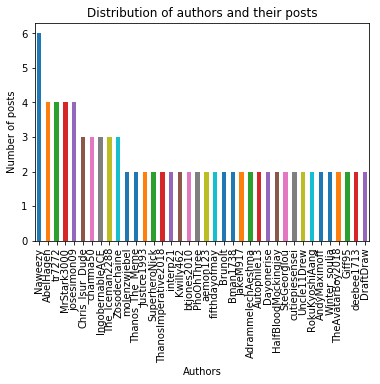

In [45]:
# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [47]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

In [48]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [49]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [50]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

,id,score,author,num_comments,subreddit
0,935qhl,76609,Zosodechaine,8100,marvelstudios
1,b4jgjw,30617,Zosodechaine,2034,marvelstudios
2,96ysua,29234,Zosodechaine,1037,marvelstudios
3,8jofyx,15977,Zosodechaine,170,StarWars
4,bui98o,5025,Zosodechaine,260,gaming
5,9hafcu,2080,Zosodechaine,106,TheLastAirbender
6,9uh5ah,1815,Zosodechaine,24,marvelstudios
7,bldqt2,1716,Zosodechaine,19,marvelstudios
8,bz74xl,1704,Zosodechaine,93,marvelstudios
9,a1tm33,1302,Zosodechaine,95,marvelstudios


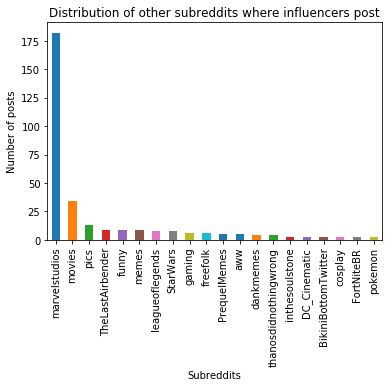

In [52]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [53]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

,author,subreddit
0,Zosodechaine,marvelstudios
1,Zosodechaine,marvelstudios
2,Zosodechaine,marvelstudios
3,Zosodechaine,StarWars
4,Zosodechaine,gaming


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


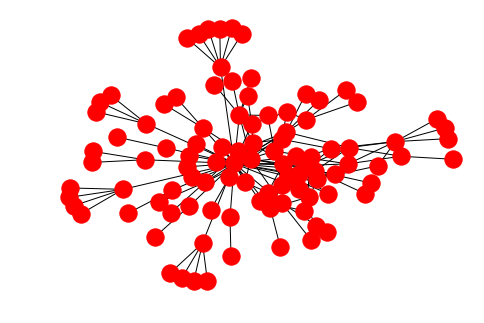

In [54]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

## Final Approach

In [55]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 

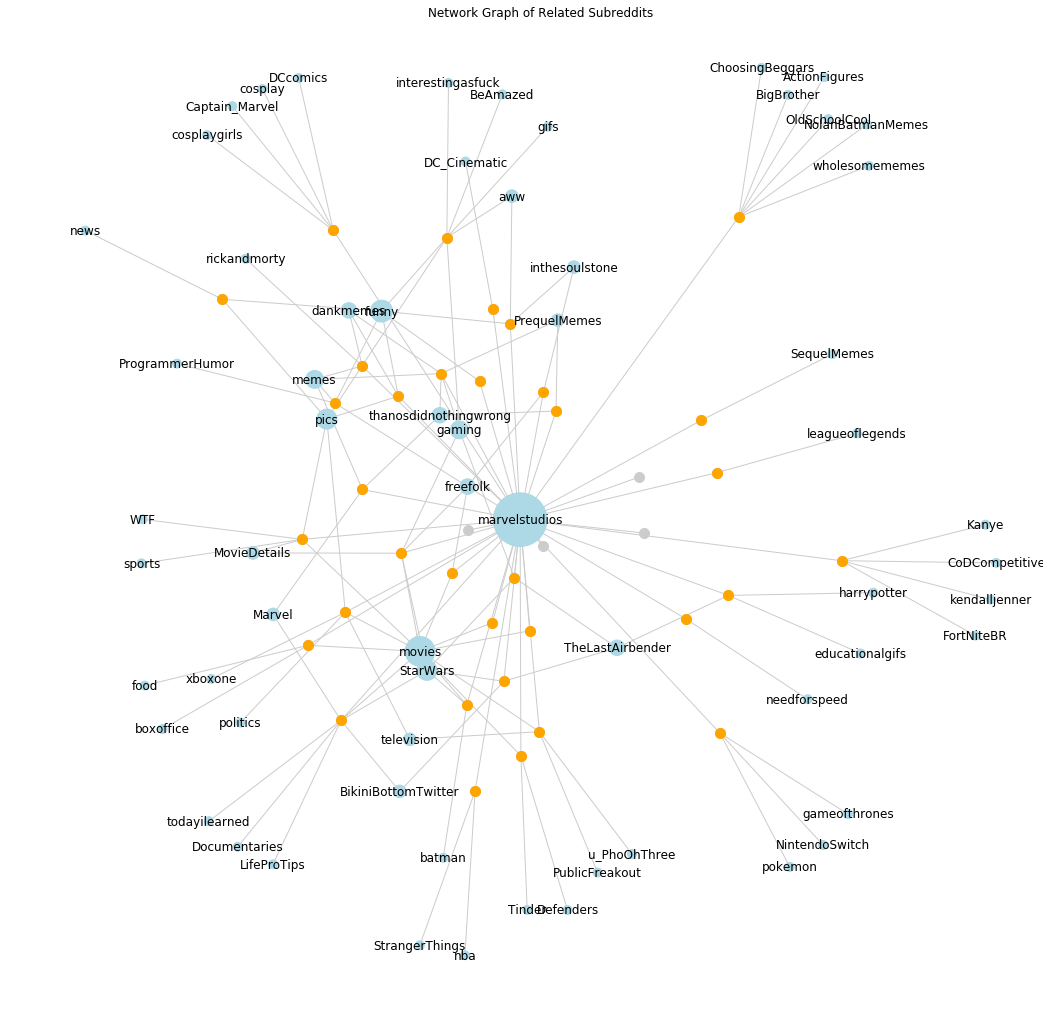

In [65]:
plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

In [66]:
g.degree('movies') # To check the number of out-degrees for a subreddit, if interested 

11